Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn.metrics import roc_curve
from sklearn import metrics
import re
import os
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Embedding, Dropout , Bidirectional
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy
from matplotlib import pyplot
from keras.regularizers import l2


In [2]:
dataset= pd.read_csv(r'G:\4th Semester\LFD\Sentiment-Analysis-with-LSTM\Sentiment Analysis with LSTM\data\Tweets23.csv')
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,text,airline_sentiment_gold,name,negativereason_gold,retweet_count,tweet_coord,tweet_created,tweet_location,user_timezone
0,567778000000000000,neutral,1.0,NaN,NaN,Southwest,@SouthwestAir what does TSA Pre on my boarding...,NaN,Jewelzz_,NaN,0,NaN,17/2/2015 12:08,TX,America/Chicago
1,568644000000000000,negative,1.0,Late Flight,0.7065,US Airways,@USAirways I have been on three planes for fli...,NaN,CourtneyEMcCoy,NaN,0,NaN,19/2/2015 21:31,Williamson West Virginia,Eastern Time (US & Canada)
2,570108000000000000,negative,1.0,Late Flight,0.6405,US Airways,@USAirways yes it landed at 11:40am. Should no...,NaN,jakenemmasmom,NaN,0,NaN,23/2/2015 22:30,NaN,NaN
3,568219000000000000,negative,1.0,Lost Luggage,1.0000,US Airways,@USAirways being told 'tough break and this is...,NaN,scheds14,NaN,0,NaN,18/2/2015 17:21,"Phoenix, AZ",NaN
4,570209000000000000,negative,1.0,Late Flight,0.6685,American,"@AmericanAir yes starting w/ flight 1278, gett...",NaN,DonnyrMartin,NaN,0,NaN,24/2/2015 5:09,"Waco, TX",Central Time (US & Canada)


In [3]:
dataset.shape

(14640, 15)

<AxesSubplot:>

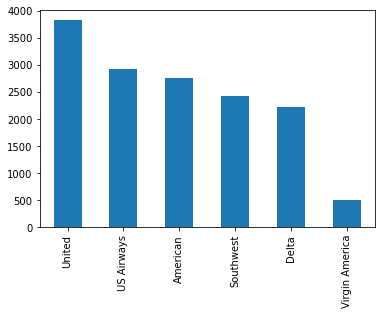

In [4]:
dataset['airline'].value_counts().plot.bar() 

Fetch the data of the tweets for the airline

In [5]:
dataset = dataset[['airline_sentiment', 'text']]
dataset.head()

,airline_sentiment,text
0,neutral,@SouthwestAir what does TSA Pre on my boarding...
1,negative,@USAirways I have been on three planes for fli...
2,negative,@USAirways yes it landed at 11:40am. Should no...
3,negative,@USAirways being told 'tough break and this is...
4,negative,"@AmericanAir yes starting w/ flight 1278, gett..."


Visualize the data
(For text , plot according to the lenght of the texts and count of the max length

<AxesSubplot:ylabel='Frequency'>

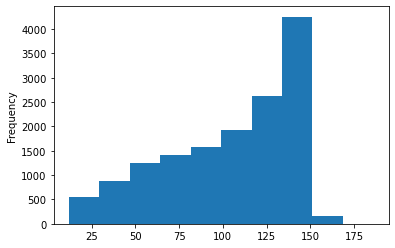

In [6]:
dataset['text'].str.len().plot.hist()

In [7]:
dataset['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

<AxesSubplot:>

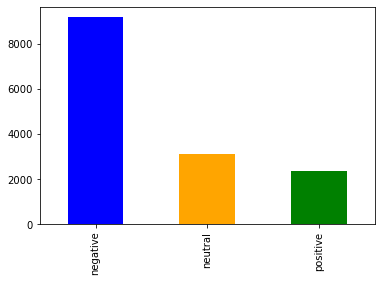

In [8]:
dataset['airline_sentiment'].value_counts().plot.bar(color=['blue','orange','green'])

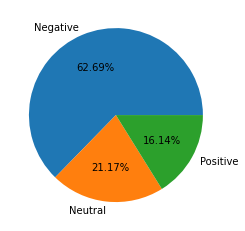

In [9]:

label=['Negative','Neutral','Positive']
plt.pie(dataset.groupby('airline_sentiment')['airline_sentiment'].count(),autopct="%.2f%%",labels=label)
plt.show()

Data Preprocessing

In [10]:
# Make small letter 
dataset['text'] = dataset['text'].apply(lambda x: x.lower())
#remove special character and keep number and character with space
dataset['text'] = dataset['text'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', "", x))
dataset['text'].head()

0    southwestair what does tsa pre on my boarding ...
1    usairways i have been on three planes for flig...
2    usairways yes it landed at 1140am should not t...
3    usairways being told tough break and this is h...
4    americanair yes starting w flight 1278 getting...
Name: text, dtype: object

Tokenization

In [11]:
#convert the text into 5000 most frequent words
# each word is represented by a unique integer. 
tokenizer = Tokenizer(num_words = 5000, split = " ")
tokenizer.fit_on_texts(dataset['text'].values)
#for single word text
X = tokenizer.texts_to_sequences(dataset['text'].values)
#to make same length
X = pad_sequences(X)
X[:7]


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   16,   57,  207,  691, 1427,    9,   11,  211,  370,  563],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   12,    3,   22,   45,    9,  482,  346,
           7,    8,   10,   72,  340,  222,    2,  410,  208,   42,  729],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,   12,  167,
          20,  429,   27, 4598,  120,   24,  148,  143,  396,   56,    1,
         128,  495,  213,  674,   23, 3092,    3,   76,   22,   29,   93],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,   12,  195,
         147, 1428, 1311,   10,   29,   14,   63,   20,   14,   14,  390,
           6,   70,  136,  266,   19,   58,   11,  142,   49,   32,  141],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   

Create Model

In [12]:
#totaldataset
X.shape

(14640, 33)

Classifier Algorithm

In [13]:
model =Sequential()
#convert the integer encoded data in a 256 lenght vector
model.add(Embedding(5000, 256, input_length = X.shape[1]))
#prevents overfitting and drop random layer 
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.3))
#we need to represent data as vectors
model.add(Dense(3, activation = 'softmax'))



In [14]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 256)           1280000   
                                                                 
 dropout (Dropout)           (None, 33, 256)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               73984     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 1,354,179
Trainable params: 1,354,179
Non-trainable params: 0
______________________________________________

In [15]:
#used for data manipulation.It converts categorical data into dummy or indicator variables
y = pd.get_dummies(dataset['airline_sentiment']).values
[print(dataset['airline_sentiment'][i], y[i]) for i in range(0,7)]

neutral [0 1 0]
negative [1 0 0]
negative [1 0 0]
negative [1 0 0]
negative [1 0 0]
negative [1 0 0]
positive [0 0 1]


[None, None, None, None, None, None, None]

In [16]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)
X_train, X_vld, y_train, y_vld = train_test_split(X_train, y_train, test_size=0.15, random_state= 0)

print('Train:         ', X_train.shape, y_train.shape)
print('Validation Set:', X_vld.shape, y_vld.shape)
print('Test Set:      ', X_test.shape, y_test.shape)

Train:          (10577, 33) (10577, 3)
Validation Set: (1867, 33) (1867, 3)
Test Set:       (2196, 33) (2196, 3)


In [17]:
checkpoint_filepath = os.getcwd()
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
callbacks = [EarlyStopping(patience=2), model_checkpoint_callback]

Model Training

In [18]:
#fit() is for training the model with the given inputs 
batch_size = 64
epochs = 5
history=model.fit(X_train,y_train,validation_data=(X_vld, y_vld) ,epochs = epochs, batch_size = batch_size, verbose = 2)

Epoch 1/5
166/166 - 13s - loss: 0.9351 - accuracy: 0.6946 - val_loss: 0.6911 - val_accuracy: 0.7761 - 13s/epoch - 78ms/step
Epoch 2/5
166/166 - 8s - loss: 0.5852 - accuracy: 0.8222 - val_loss: 0.6065 - val_accuracy: 0.8002 - 8s/epoch - 47ms/step
Epoch 3/5
166/166 - 8s - loss: 0.4644 - accuracy: 0.8619 - val_loss: 0.5827 - val_accuracy: 0.8099 - 8s/epoch - 50ms/step
Epoch 4/5
166/166 - 8s - loss: 0.3881 - accuracy: 0.8878 - val_loss: 0.5910 - val_accuracy: 0.7970 - 8s/epoch - 49ms/step
Epoch 5/5
166/166 - 9s - loss: 0.3393 - accuracy: 0.9045 - val_loss: 0.6156 - val_accuracy: 0.7997 - 9s/epoch - 54ms/step


Evaluate the model

In [19]:
score_test = model.evaluate(X_test, y_test, verbose=0)
score_train = model.evaluate(X_train, y_train, verbose=0)
score_val = model.evaluate(X_vld, y_vld, verbose=0)

# Print metrics
print("Accuracy for Test: %.2f%%" % (score_test[1]*100)) 
print("Accuracy for Train: %.2f%%" % (score_train[1]*100))
print("Accuracy for Validation: %.2f%%" % (score_val[1]*100))
#print('Test loss:', score[0]) 

Accuracy for Test: 78.87%
Accuracy for Train: 93.21%
Accuracy for Validation: 79.97%


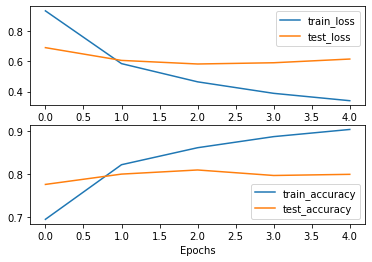

In [20]:
# plot loss during training

pyplot.subplot(211)
#pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='test_loss')
pyplot.legend()
# plot accuracy during training

pyplot.subplot(212)
#pyplot.title('Accuracy')
plt.xlabel('Epochs')
pyplot.plot(history.history['accuracy'], label='train_accuracy')
pyplot.plot(history.history['val_accuracy'], label='test_accuracy')
pyplot.legend()
pyplot.show()

In [21]:
prediction = model.predict(X_test)
[print(dataset['text'][i], prediction[i], y_test[i]) for i in range(0, 10)]

69/69 [==============================] - 2s 11ms/step
southwestair what does tsa pre on my boarding pass mean httptco0hmmqczkcf [9.9496764e-01 4.4965846e-03 5.3578761e-04] [1 0 0]
usairways i have been on three planes for flight 1907 and still havent left the ground bad service sad [0.974842   0.02071538 0.00444265] [0 1 0]
usairways yes it landed at 1140am should not take another 12 hours to go 40 min drive was assured i would have this am [0.90633714 0.06816345 0.02549945] [1 0 0]
usairways being told tough break and this is how it is is unacceptable you cant even tell me when my bags will be here [0.06643732 0.16674848 0.7668142 ] [0 0 1]
americanair yes starting w flight 1278 getting me home more than 48 hours late flightr record locator bsuxlu [9.976131e-01 1.957512e-03 4.293805e-04] [1 0 0]
americanair derekc21  to my surprise  ba doesnt  have  me registered in the system  i was getting hopeful  lets step it up  okay  [0.14037344 0.08410043 0.77552617] [1 0 0]
americanair robertd

[None, None, None, None, None, None, None, None, None, None]

Evaluating the Performance: AUC Score

In [22]:
auc_lstm = roc_auc_score(y_test, prediction)
auc_lstm
print('auc_lstm  : {:.4f}'.format(auc_lstm))

auc_lstm  : 0.8942


69/69 [==============================] - 1s 11ms/step


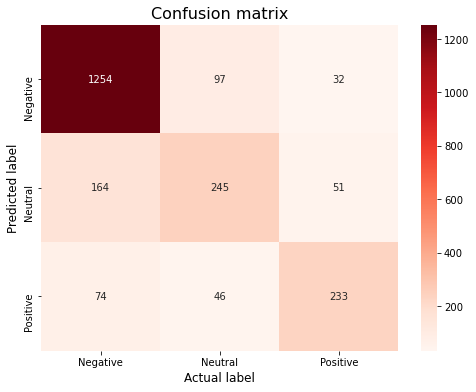

In [23]:
def plot_confusion_matrix(model, X_test, y_test):
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    y_pred = model.predict(X_test)
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Reds, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

In [24]:
y_pred = model.predict(X_test)
#Returns the indices of the maximum values along an axis
y_pred = np.argmax(y_pred, axis=1)


69/69 [==============================] - 1s 11ms/step


In [25]:
#used for data manipulation.It converts categorical data into dummy or indicator variables
y_pred_enc = pd.get_dummies(y_pred)
#y_test_enc = np.argmax(np.array(y_test),axis=1)

In [27]:
print(classification_report(y_test,y_pred_enc))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1383
           1       0.63      0.53      0.58       460
           2       0.74      0.66      0.70       353

   micro avg       0.79      0.79      0.79      2196
   macro avg       0.74      0.70      0.72      2196
weighted avg       0.78      0.79      0.78      2196
 samples avg       0.79      0.79      0.79      2196

